In [1]:
# what is the increase in PPI / PDI from 
# testing multiple isoforms per gene
import pandas as pd
from matplotlib import pyplot as plt

from data_loading import load_y2h_isoform_data, load_y1h_pdi_data, load_annotated_TFiso1_collection

y2h = load_y2h_isoform_data()
y1h = load_y1h_pdi_data()
tfs = load_annotated_TFiso1_collection()
# TODO: add filtering as an argument
tfs = {k: v for k, v in tfs.items() if len(v.cloned_isoforms) >= 2}

reading from cache


In [2]:
tfs['ARNTL'].cloned_reference_isoform

Clone acc: ARNTL|1/2|08H08
Isoform: ARNTL-201 / ENSP00000374357 / ENST00000389707
length: 625 aa

In [3]:
# number of cloned, uncloned and novel isoforms
df = pd.DataFrame([(name, tf.cloned_MANE_select_isoform) for name, tf in tfs.items()],
             columns=['gene', 'cloned_MANE_select_isoform'])
df.head()

,gene,cloned_MANE_select_isoform
0,ZBTB18,True
1,PRRX1,True
2,POU2F1,False
3,ATF3,True
4,GRHL3,True


In [4]:
df.shape

(246, 2)

In [5]:
df['cloned_MANE_select_isoform'].value_counts(dropna=False)

True     164
False     65
None      17
Name: cloned_MANE_select_isoform, dtype: int64

In [6]:
df.loc[df['cloned_MANE_select_isoform'].isnull()]

,gene,cloned_MANE_select_isoform
49,ELF2,None
50,ZNF131,None
67,PLAGL1,None
68,TEAD3,None
105,CREM,None
111,EBF3,None
113,ZNF438,None
127,SOX6,None
149,ZBTB1,None
154,OTX2,None


In [7]:
df.loc[df['cloned_MANE_select_isoform'] == False]

,gene,cloned_MANE_select_isoform
2,POU2F1,False
12,NR5A2,False
14,PRDM16,False
20,ESRRG,False
21,ZNF692,False
...,...,...
229,TEAD2,False
232,ZNF414,False
238,PATZ1,False
243,HDX,False


In [8]:
cloned_reference = {tf.cloned_reference_isoform.clone_acc for tf in tfs.values()}

In [9]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [10]:
cloned_MANE = set(df.loc[df['cloned_MANE_select_isoform'] == True, 'gene'].values)

In [11]:
n_ppi_gene = (y2h.loc[y2h['Y2H_result'] == True, :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
n_ppi_isoform = (y2h.loc[(y2h['Y2H_result'] == True) &
                         y2h['ad_clone_acc'].isin(cloned_reference), :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
ppi_increase = n_ppi_gene - n_ppi_isoform
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{ppi_increase.sum()} total PPIs '
      f'({n_ppi_gene.sum()} total, '
      f'+{ppi_increase.sum() / (n_ppi_gene.sum() - ppi_increase.sum()):.1%})')
print(f'{(ppi_increase > 0).sum()} of '
      f'{ppi_increase.shape[0]} genes had ≥ 1 extra PPI'
      f' ({(ppi_increase > 0).mean():.0%})')
# average per gene

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
173.0 total PPIs (786 total, +28.2%)
19 of 63 genes had ≥ 1 extra PPI (30%)


<ipython-input-13-16f74ad5270d>:7: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../figures/ppi_increase.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


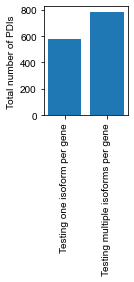

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_ppi_isoform.sum(), n_ppi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/ppi_increase.pdf',
            bbox_inches='tight')


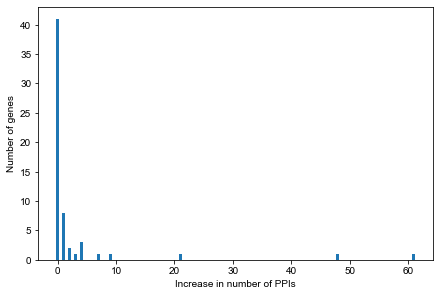

In [14]:
fig, ax = plt.subplots(1, 1)
ppi_increase.plot.hist(bins=int(ppi_increase.max()) * 2 + 1,
                       range=(-0.25, ppi_increase.max() + 0.25),
                       ax=ax)
ax.set_ylabel('Number of genes')
ax.set_xlabel('Increase in number of PPIs')
fig.savefig('../figures/PPI_increase_hist.pdf',
            bbox_inches='tight')

In [15]:
ppi_increase.sort_values(ascending=False).head()

ad_gene_symbol
ZNF451     61.0
IKZF2      48.0
ZNF438     21.0
ZSCAN18     9.0
ZBTB44      7.0
Name: db_gene_symbol, dtype: float64

In [16]:
# check the increase is not due to lots of failed tests with the reference
(y2h.loc[(y2h['Y2H_result'].isnull()) &
                         y2h['ad_clone_acc'].isin(cloned_reference), :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique()).sum()

12

In [17]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [18]:
n_ppi_gene = (y2h.loc[y2h['ad_gene_symbol'].isin(cloned_MANE), :].loc[y2h['Y2H_result'] == True, :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
n_ppi_isoform = (y2h.loc[y2h['ad_gene_symbol'].isin(cloned_MANE), :].loc[(y2h['Y2H_result'] == True) &
                         y2h['ad_clone_acc'].isin(cloned_reference), :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
ppi_increase = n_ppi_gene - n_ppi_isoform
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{ppi_increase.sum()} total PPIs '
      f'({n_ppi_gene.sum()} total, '
      f'+{ppi_increase.sum() / (n_ppi_gene.sum() - ppi_increase.sum()):.1%})')
print(f'{(ppi_increase > 0).sum()} of '
      f'{ppi_increase.shape[0]} genes had ≥ 1 extra PPI'
      f' ({(ppi_increase > 0).mean():.0%})')
# average per gene

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
26.0 total PPIs (530 total, +5.2%)
11 of 42 genes had ≥ 1 extra PPI (26%)


<ipython-input-19-6ff6329acc03>:7: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../figures/ppi_increase_MANE_only.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


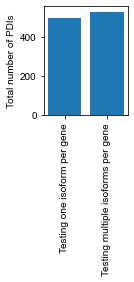

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_ppi_isoform.sum(), n_ppi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/ppi_increase_MANE_only.pdf',
            bbox_inches='tight')

In [20]:
n_pdi_gene = y1h.groupby('tf').any().iloc[:, 1:].sum(axis=1)
n_pdi_isoform = y1h.loc[y1h['unique_acc'].isin(cloned_reference), :].groupby('tf').any().iloc[:, 1:].sum(axis=1)

n_pdi_gene = n_pdi_gene.loc[n_pdi_isoform.index]

pdi_increase = (n_pdi_gene - n_pdi_isoform).fillna(n_pdi_gene)
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{pdi_increase.sum()} total PDIs '
      f'({n_pdi_gene.sum()} total, '
      f'+{pdi_increase.sum() / (n_pdi_gene.sum() - pdi_increase.sum()):.1%})')
print(f'{(pdi_increase > 0).sum()} of '
      f'{pdi_increase.shape[0]} genes had ≥ 1 extra PDI'
      f' ({(pdi_increase > 0).mean():.0%})')

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
72.0 total PDIs (360.0 total, +25.0%)
18 of 57 genes had ≥ 1 extra PDI (32%)


<ipython-input-21-3b61a2676965>:7: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../figures/pdi_increase.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


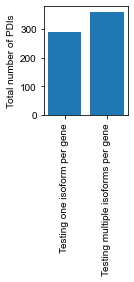

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_pdi_isoform.sum(), n_pdi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/pdi_increase.pdf',
            bbox_inches='tight')


In [22]:
n_pdi_gene = y1h.loc[y1h['tf'].isin(cloned_MANE), :].groupby('tf').any().iloc[:, 1:].sum(axis=1)
n_pdi_isoform = y1h.loc[y1h['tf'].isin(cloned_MANE), :].loc[y1h['unique_acc'].isin(cloned_reference), :].groupby('tf').any().iloc[:, 1:].sum(axis=1)

n_pdi_gene = n_pdi_gene.loc[n_pdi_isoform.index]

pdi_increase = (n_pdi_gene - n_pdi_isoform).fillna(n_pdi_gene)
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{pdi_increase.sum()} total PDIs '
      f'({n_pdi_gene.sum()} total, '
      f'+{pdi_increase.sum() / (n_pdi_gene.sum() - pdi_increase.sum()):.1%})')
print(f'{(pdi_increase > 0).sum()} of '
      f'{pdi_increase.shape[0]} genes had ≥ 1 extra PDI'
      f' ({(pdi_increase > 0).mean():.0%})')

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
62.0 total PDIs (326.0 total, +23.5%)
14 of 43 genes had ≥ 1 extra PDI (33%)


<ipython-input-23-8b855589a360>:7: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../figures/pdi_increase_MANE_only.pdf',


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


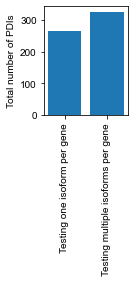

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_pdi_isoform.sum(), n_pdi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/pdi_increase_MANE_only.pdf',
            bbox_inches='tight')